In [64]:
import time

In [2]:
from numpy.linalg import inv
from numpy import log
import numpy as np

import matplotlib.pyplot as plt

from multivariate_util import *

In [3]:
def log_likelihood():
    n  = len(X)
    u_ = [(_-mu).T.dot(inv(cov).dot(_-mu)) for _ in X]
    return -.5*n*p*log(2 * np.pi) -.5*n*log(np.linalg.det(cov)) - .5 * sum(u_)

In [4]:
def m_step(X, mu, cov, u, tau):
    mu_ = (tau * u * X).sum(axis=0) / (tau * u).sum()
    
    cov_ = np.array([[0,0], [0,0]], dtype=np.float32)
    for idx, delta in enumerate(X - mu_):
        delta = delta.reshape(-1, 1)
        cov_ += (tau[idx] * u[idx] * delta).dot(delta.T)

    cov_ /= tau.sum()
    
    if mu_[0] == np.nan:
        print mu_
    
    return mu_, cov_

In [5]:
def get_random(X):
    size = len(X)
    idx = np.random.choice(range(size))
    return X[idx]

## Expectation Maximization with Mixtures
Implementation of a mixture model using the t distribution.
#### Source
1. D. Peel, G. J. McLachlan; Robust mixture modelling using the t distribution. Statistics and Computing (2000) 10, 339-348.

### Generating a sample
I'll generate two samples with distinct parameters and merge them into one.

In [24]:
actual_mu01  = [0,0]
actual_cov01 = [[1,0], [0,1]]
actual_df01  = 15

In [25]:
actual_mu02  = [1,1]
actual_cov02 = [[.5, 0], [0, 1.5]]
actual_df02  = 15

In [26]:
size = 300

In [27]:
x01 = multivariate_t_rvs(m=actual_mu01, S=actual_cov01, df=actual_df01, n=size)
x02 = multivariate_t_rvs(m=actual_mu02, S=actual_cov02, df=actual_df02, n=size)

In [28]:
X = np.concatenate([x01, x02])
X.shape

(600L, 2L)

### Plotting the sample with actual parameters

In [42]:
x, y = np.mgrid[-3:3:.1, -3:4:.1]
xy = np.column_stack([x.ravel(),y.ravel()])
xy.shape

t01 = multivariate_t(actual_mu01, actual_cov01, actual_df01)
t02 = multivariate_t(actual_mu02, actual_cov02, actual_df02)

z01 = []
z02 = []
for _ in xy:
    z01.append(t01.pdf(_.reshape(1, -1)))
    z02.append(t02.pdf(_.reshape(1, -1)))
z01 = np.reshape(z01, x.shape)
z02 = np.reshape(z02, x.shape)

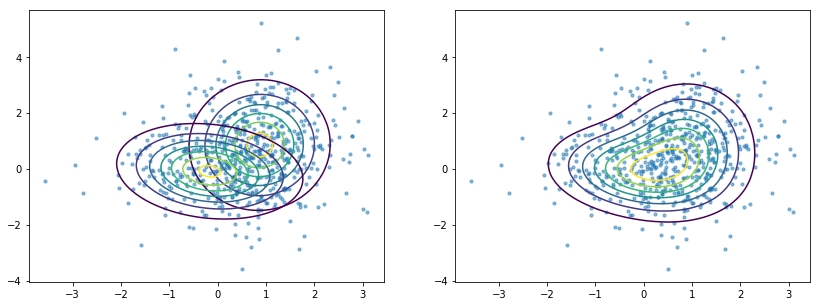

In [70]:
fig = plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.scatter(X.T[0], X.T[1], s=10, alpha=.5)
plt.contour(x, y, z01)
plt.contour(x, y, z02)

plt.subplot(122)
plt.scatter(X.T[0], X.T[1], s=10, alpha=.5)
plt.contour(x, y, z01+z02)

fig.savefig('draft04 - actual.png')

plt.show()

### Estimating parameters

In [72]:
n_iter = 50 # number of iterations

# guessing mixture 01
mu01  = get_random(X)
cov01 = np.cov(X.T.copy())
# known variables mix01
df01  = 15
p01 = 2

# guessing mixture 02
mu02  = get_random(X)
cov02 = np.cov(X.T.copy())
# known variables mix 02
df02 = 15
p02 = 2

# guessing the pi parameter
pi = .5

t01 = multivariate_t(mu01, cov01, df01)
t02 = multivariate_t(mu02, cov02, df02)

start = time.time()
for i in range(n_iter):
    # E-step: Calculating tau
    wp1 = t01.pdf(X) * pi
    wp2 = t02.pdf(X) * (1 - pi)
    wp_total = wp1 + wp2

    wp1 /= wp_total; wp1 = wp1.reshape(-1, 1)
    wp2 /= wp_total; wp2 = wp2.reshape(-1, 1)

    # E-Step: Calculating u
    u01 = []
    for delta in X-mu01:
        u01.append(delta.dot(inv(cov01)).dot(delta))
    u01 = np.array(u01)
    u01 = (df01 + p01)/(df01 + u01); u01 = u01.reshape(-1, 1)

    u02 = []
    for delta in X-mu02:
        u02.append(delta.dot(inv(cov02)).dot(delta))
    u02 = np.array(u02)
    u02 = (df02 + p02)/(df02 + u02); u02 = u02.reshape(-1, 1)

    # M-step
    mu01, cov01 = m_step(X, mu01, cov01, u01, wp1)
    mu02, cov02 = m_step(X, mu02, cov02, u02, wp2)
    
    t01.mu = mu01; t01.sigma = cov01
    t02.mu = mu02; t02.sigma = cov02
    
    pi = wp1.sum()/len(wp1)

print 'elapsed time: %s' % (time.time() - start)
print 'pi: {0:4.06}'.format(pi)
print 'mu01: {0}; mu02: {1}'.format(mu01, mu02)
print 'cov01\n%s' % cov01
print 'cov02\n%s' % cov02

elapsed time: 6.57799983025
pi: 0.652658
mu01: [ 0.84908724  0.80374505]; mu02: [-0.20360132 -0.09132756]
cov01
[[ 0.59094048  0.02786437]
 [ 0.02786437  1.50229001]]
cov02
[[ 0.9410702  -0.1348049 ]
 [-0.1348049   0.71941221]]


In [73]:
xmin, xmax = min(X.T[0]), max(X.T[0])
ymin, ymax = min(X.T[1]), max(X.T[1])

In [74]:
x, y = np.mgrid[xmin:xmax:.1, ymin:ymax:.1]
xy = np.column_stack([x.ravel(),y.ravel()])
xy.shape

t01 = multivariate_t(mu01, cov01, df01)
t02 = multivariate_t(mu02, cov02, df02)

z01 = []
z02 = []
z03 = []
for _ in xy:
    _ = _.reshape(1, -1)
    z01.append(t01.pdf(_))
    z02.append(t02.pdf(_))
    z03.append(pi*t01.pdf(_) + (1-pi)*t02.pdf(_))
z01 = np.reshape(z01, x.shape)
z02 = np.reshape(z02, x.shape)
z03 = np.reshape(z03, x.shape)

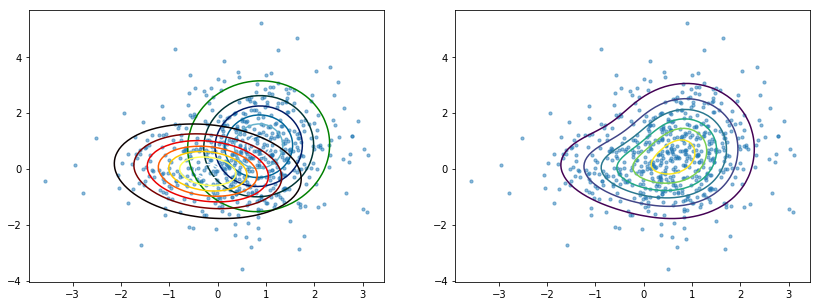

In [77]:
fig = plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.scatter(X.T[0], X.T[1], s=10, alpha=.5)
plt.contour(x, y, z01, cmap='ocean')
plt.contour(x, y, z02, cmap='hot')

plt.subplot(122)
plt.scatter(X.T[0], X.T[1], s=10, alpha=.5)
plt.contour(x, y, z03)

fig.savefig('draft04 - estimated.png')

plt.show()